In [1]:
import numpy as np
import laspy
import cv2
from TronGisPy import GisIO, CRS, Normalizer, Interpolation
import CSF 
import os, sys, gc, subprocess # file system package
import pickle, json, shutil, itertools # file processing basic package
import laspy, PySaga, gdal # geo package
#import cv2 # open computer vision package
import pandas as pd
import geopandas as gpd
import numba
from scipy.stats import entropy
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances, pairwise_distances_argmin
from util.las import *
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.ndimage.measurements import label

In [2]:
%%time
las_fp = os.path.join("data", "123.las")
ground_las_fp = os.path.join("tmp", "classified_ground.las")

X_ref_fp = "./tmp/street_X_ref.tif"
X_ref_ground_fp = "./tmp/ground_X_ref.tif"
street_las = CloudPoint(las_fp)
ground_las = CloudPoint(ground_las_fp)
DTM_fp = "tmp/DTM.tif"
DSM_fp = "tmp/DSM.tif"
DSM_minus_DTM_fp = "tmp/DSM_minusDTM.tif"

Wall time: 5.03 s


In [7]:
street_las.header

([295987.85824990843, 2772907.968000366, 20.25949972915649],
 [0.00025, 0.00025, 0.00025])

In [3]:
resolution = 0.05
pad = resolution / 2
x_min, x_max, y_min, y_max = street_las.get_las_boundary(return_poly=False)
x_min, x_max = x_min - pad, x_max + pad
y_min, y_max = y_min - pad, y_max + pad
geo_transform = (x_min, resolution, 0, y_max, 0, -resolution)
wkt_3826 = CRS.get_wkt_from_epsg(3826)
cols = int((x_max - x_min) // resolution) + 1
rows = int((y_max - y_min) // resolution) + 1
X = np.random.rand(rows, cols)
GisIO.write_output_tif(X, X_ref_fp, geo_transform=geo_transform, projection=wkt_3826, gdaldtype=gdal.GDT_Float32)
X_ref = GisIO.get_nparray(X_ref_fp)
print(X_ref.shape)

(3053, 3256, 1)


In [4]:
%%time


las_data = np.array([ground_las.data[i] for i in ground_las.using_attr]).T
X_ref = GisIO.get_nparray(X_ref_fp)
cols, rows, bands, _, _, _, _ = GisIO.get_geo_info(X_ref_fp)
X_ref_extent = GisIO.get_extent(X_ref_fp, False)

las_npidxs = CRS.numba_transfer_group_coord_to_npidx(las_data, geo_transform) # Wall time: 35 s
las_npidxs, las_npidxs.shape

Wall time: 22.3 s


(array([[2409,  769],
        [2348,  808],
        [2399,  780],
        ...,
        [ 402, 2387],
        [ 364, 2457],
        [ 311, 2515]], dtype=int64),
 (14263751, 2))

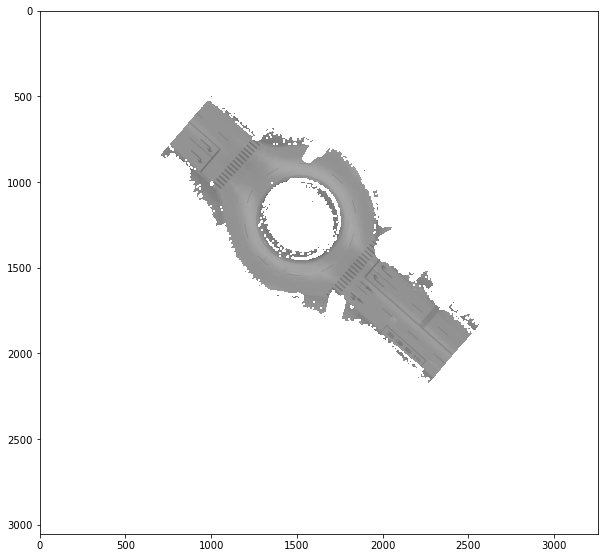

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
las_ground_intensity_max = ground_las.proj_las_to_2D_plane(las_npidxs, X_ref[:,:,0], feature='intensity', operator='max' )
ax.imshow(las_ground_intensity_max, cmap="gray_r")

C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


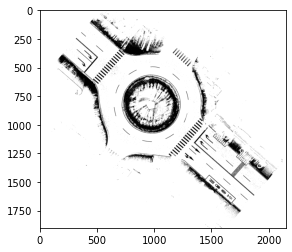

In [6]:
fig, ax = plt.subplots(1,1)

las_ground_intensity_max_copy = las_ground_intensity_max.copy()
las_ground_intensity_max_copy[las_ground_intensity_max<6500] = 0
las_ground_intensity_max_copy[np.isnan(las_ground_intensity_max)] = 0

zero_idx = np.array(las_ground_intensity_max_copy==0)
non_zero_idx = np.array(las_ground_intensity_max_copy!=0)
las_ground_intensity_max_copy[zero_idx] = 0
las_ground_intensity_max_copy[non_zero_idx] = 1

ax.imshow(las_ground_intensity_max_copy[400:2300, 550:2700], cmap="gray_r")



[[[  -69.            2.3561945]]

 [[ -392.            2.3561945]]

 [[ -290.            2.3038347]]

 ...

 [[-1043.            3.0892327]]

 [[-1543.            3.1241393]]

 [[-1535.            3.1241393]]]


(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

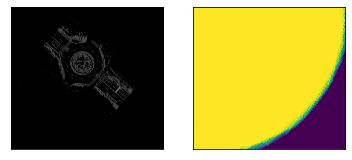

In [28]:
gray = np.uint8(las_ground_intensity_max_copy)

edges = cv2.Canny(gray,0,1)
# print(edges)
plt.subplot(121),plt.imshow(edges,'gray')
plt.xticks([]),plt.yticks([])
#hough transform
lines = cv2.HoughLines(edges,1,np.pi/180,160)
print(lines)
lines1 = lines[:,0,:]#提取为为二维
for rho,theta in lines1[:]: 
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a)) 
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),1)

plt.subplot(122),plt.imshow(img,)
plt.xticks([]),plt.yticks([])


In [17]:
np.unique(gray)

array([0., 1.])

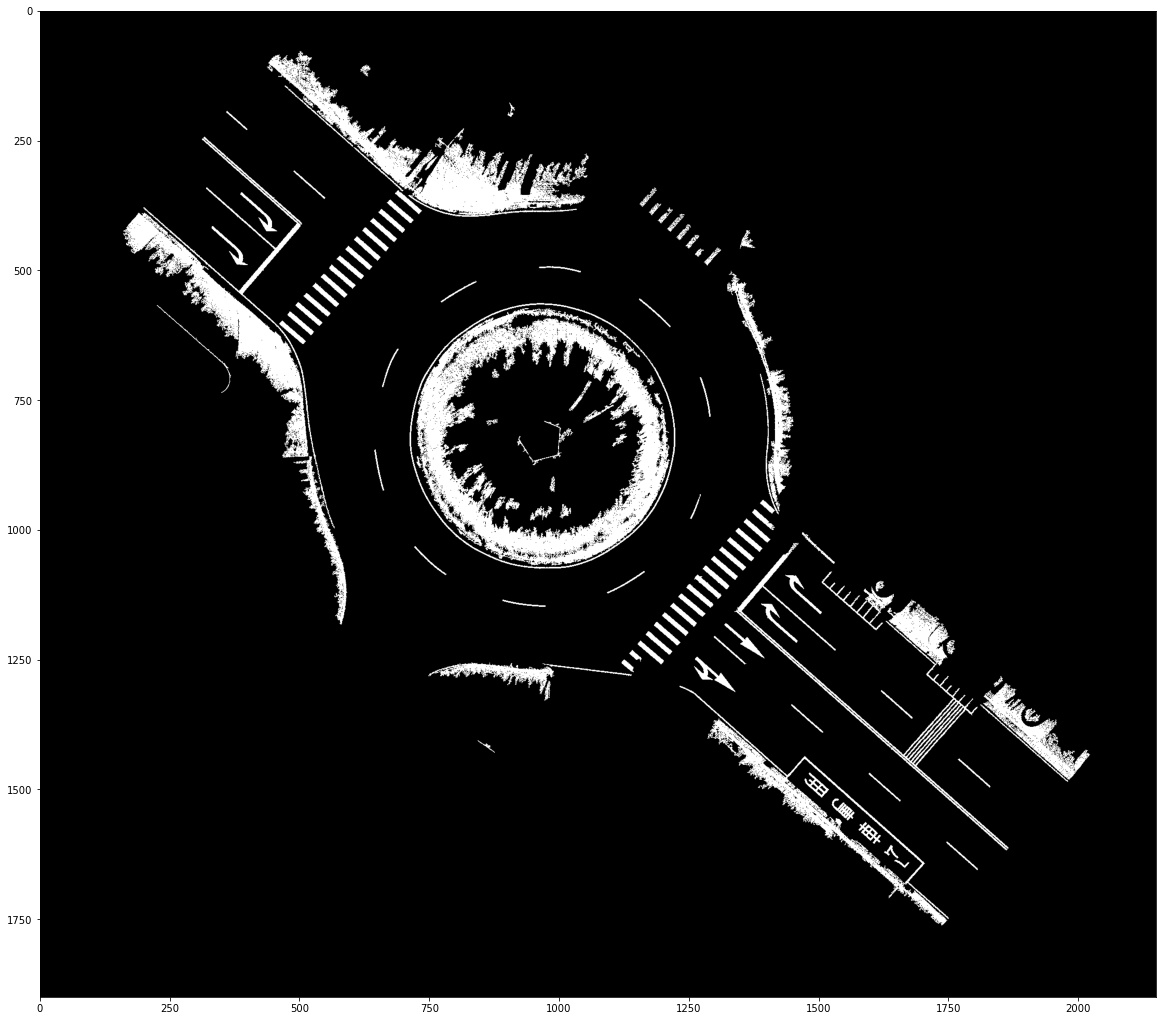

In [9]:
# from scipy.ndimage.measurements import label

# n_thresh = 100
# labeled_array, num_features = label(las_ground_intensity_max_copy)
# binc = np.bincount(labeled_array.ravel())
# noise_idx = np.where(binc <= n_thresh)
# mask = np.in1d(labeled_array, noise_idx).reshape(las_ground_intensity_max_copy.shape)
# las_ground_intensity_max_copy[mask] = 0


# fig, ax = plt.subplots(1,1, figsize=(20,20))
# ax.imshow(las_ground_intensity_max_copy[400:2300, 550:2700], cmap="gray")
# # ttt = clipped_max_copy.copy()
# # ttt[ttt==0]=-1
# # GisIO.write_output_tif(ttt, "tmp/filter_results.tif", geo_transform=geo_transform, projection=wkt_3826,
# #     gdaldtype=gdal.GDT_Int32, no_data_value=-1)

In [34]:
# npidxs_in_mask = list(zip(*np.where(las_ground_intensity_max_copy == 1)))
# df_las_npidxs = pd.DataFrame(las_npidxs, columns=['npidx_row', 'npidx_col'])
# df_las_npidxs['order_idx'] = range(len(df_las_npidxs))
# df_las_npidxs.set_index(['npidx_row', 'npidx_col'], inplace=True)
# df_order_idx = df_data_tuple.loc[npidxs_in_mask, 'order_idx']
# order_idx = df_order_idx.loc[pd.notna(df_order_idx)].astype(np.int).values

# las_data_in_mask = las_data[order_idx]
# las_npidxs_in_mask = las_npidxs[order_idx]

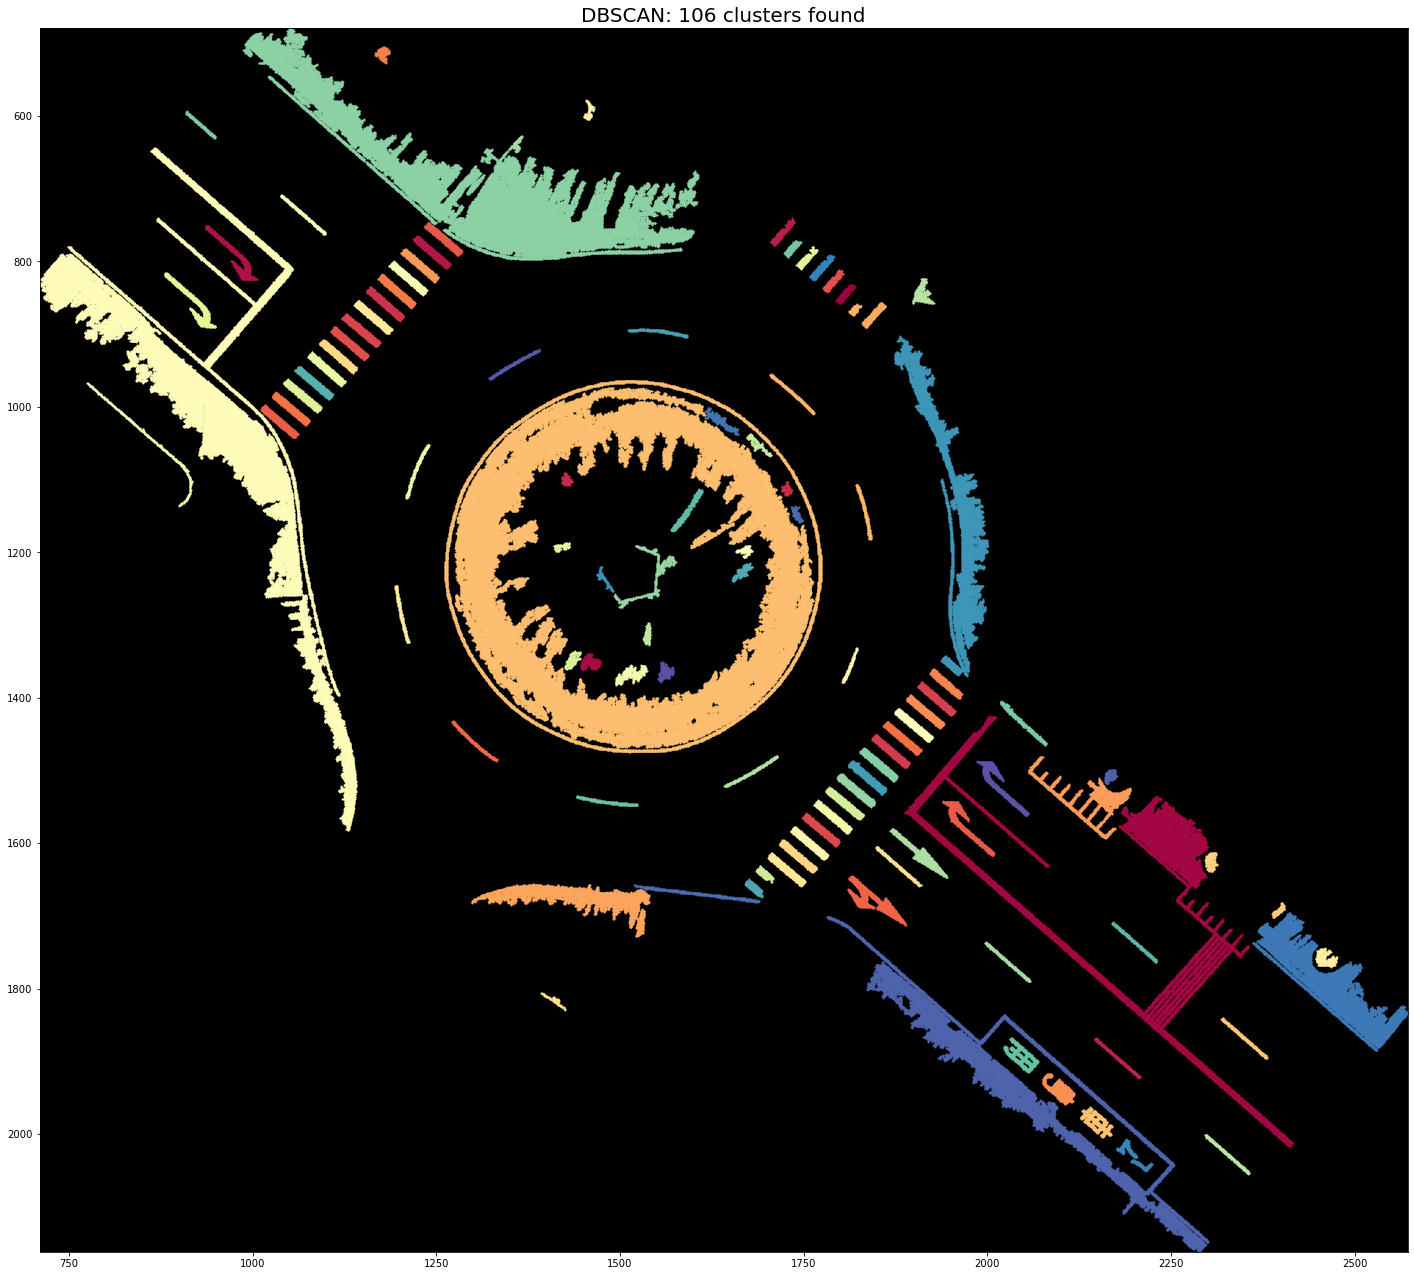

In [10]:
data = np.argwhere(las_ground_intensity_max_copy==1)
max_distance = 3
db = DBSCAN(eps=max_distance, min_samples=5).fit(data)
# Extract a mask of core cluster members
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Extract labels (-1 is used for outliers)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)

# min_x = 0
# max_x = las_ground_intensity_max_copy.shape[1]
# min_y = 0
# max_y = las_ground_intensity_max_copy.shape[0]
min_x = np.min(data[:, 0])
max_x = np.max(data[:, 0])
min_y = np.min(data[:, 1])
max_y = np.max(data[:, 1])


fig = plt.figure(figsize=(20,20))
ax = plt.subplot()
# The following is just a fancy way of plotting core, edge and outliers

# def get_random_color(size):
#     return np.array([list(np.random.choice(range(256), size=3)) for i in range(size)])
# color_map = get_random_color(n_clusters)
# cluster_rgbs = color_map[labels]

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
np.random.shuffle(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2, markeredgewidth=0.0)

    xy = data[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=3, markeredgewidth=0.0)
plt.ylim(max_x, min_x)
plt.xlim(min_y, max_y)
plt.title('DBSCAN: %d clusters found' % n_clusters, fontsize = 20)
fig.tight_layout()
plt.subplots_adjust(left=0.03, right=0.98, top=0.9, bottom=0.05)
ax.set_facecolor('xkcd:black')

C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


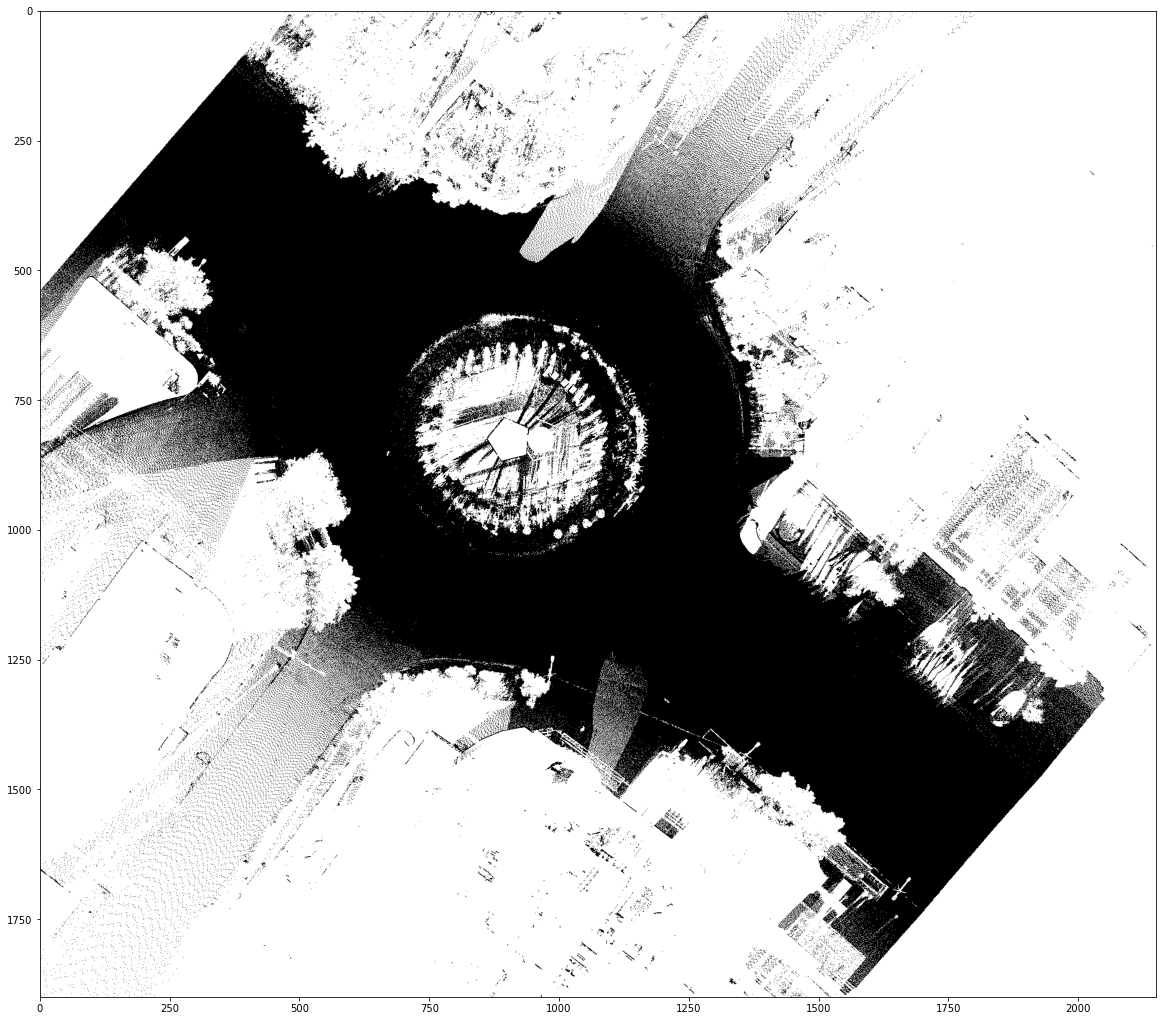

In [11]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

las_ground_intensity_max_copy_copy = las_ground_intensity_max_copy.copy()
tmp_mask = tmp
tmp_mask[tmp>=1] = 1
tmp_mask[tmp< 1] = 0
tmp_mask[np.isnan(tmp)] = 1
ax.imshow(tmp_mask[400:2300, 550:2700], cmap="gray")
# ttt = clipped_max_copy.copy()
# ttt[ttt==0]=-1
# GisIO.write_output_tif(ttt, "tmp/filter_results.tif", geo_transform=geo_transform, projection=wkt_3826,
#     gdaldtype=gdal.GDT_Int32, no_data_value=-1)

In [12]:
df_points = pd.DataFrame(las_npidxs, columns=['npidx_row', 'npidx_col'])
df_points["x"] = las_data[:, 0]
df_points["y"] = las_data[:, 1]
df_points["z"] = las_data[:, 2]
df_points["R"] = 0
df_points["G"] = 0
df_points["B"] = 0

df_points.set_index(['npidx_row', 'npidx_col'], inplace=True)
df_points.head()

,,x,y,z,R,G,B
npidx_row,npidx_col,,,,,,
2409,769,296026.28725,2.772940e+06,23.57275,0,0,0
2348,808,296028.27900,2.772943e+06,23.40575,0,0,0
2399,780,296026.86250,2.772941e+06,23.93150,0,0,0
2396,700,296022.84775,2.772941e+06,23.30325,0,0,0
2299,753,296025.51225,2.772946e+06,23.31525,0,0,0


In [13]:
%%time
las_npidxs_tuple = [tuple(p) for p in las_npidxs]

Wall time: 10.8 s


In [14]:
data_tuple = [tuple(i) for i in data]
df_data_tuple = pd.DataFrame(data_tuple, columns=['npidx_row', 'npidx_col'])
df_data_tuple['order_idx'] = range(len(df_data_tuple))
df_data_tuple.set_index(['npidx_row', 'npidx_col'], inplace=True)
df_data_tuple.tail()


order_idx
npidx_row npidx_col           
2160      2287          247814
          2288          247815
          2289          247816
2161      2287          247817
2162      2287          247818

In [15]:
%%time
df_order_idx = df_data_tuple.loc[las_npidxs_tuple, 'order_idx']
order_idx = df_order_idx.loc[pd.notna(df_order_idx)].astype(np.int).values

C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


Wall time: 1min 59s


In [16]:
using_color = np.array(colors)[db.labels_][:,:3]*255
using_color

array([[139.88235294, 208.82352941, 164.45098039],
       [139.88235294, 208.82352941, 164.45098039],
       [139.88235294, 208.82352941, 164.45098039],
       ...,
       [ 78.47058824,  99.11764706, 171.52941176],
       [ 78.47058824,  99.11764706, 171.52941176],
       [ 78.47058824,  99.11764706, 171.52941176]])

In [17]:
df_points.loc[pd.notna(df_order_idx), ['R', 'G', 'B']] = using_color[order_idx]


C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [18]:
using_color[order_idx].shape

(2542385, 3)

In [19]:
df_points.loc[pd.notna(df_order_idx)].head()

,,x,y,z,R,G,B
npidx_row,npidx_col,,,,,,
1562,1124,296044.05700,2.772982e+06,23.53125,254.862745,250.745098,183.862745
1569,1131,296044.40850,2.772982e+06,23.40125,254.862745,250.745098,183.862745
1558,1136,296044.64700,2.772983e+06,23.31025,254.862745,250.745098,183.862745
1555,1136,296044.65625,2.772983e+06,23.37275,254.862745,250.745098,183.862745
1559,1128,296044.25475,2.772983e+06,23.62425,254.862745,250.745098,183.862745


In [20]:
las_data_copy = las_data

In [21]:
las_data.shape, las_data[-5:, :]

((14263751, 10),
 array([[2.96112333e+05, 2.77304534e+06, 2.35007500e+01, 1.00000000e+00,
         1.00000000e+00, 1.77000000e+03, 1.00000000e+00, 3.02770000e+04,
         3.02770000e+04, 3.02770000e+04],
        [2.96112100e+05, 2.77304943e+06, 2.37382500e+01, 1.00000000e+00,
         1.00000000e+00, 3.32800000e+03, 1.00000000e+00, 4.39520000e+04,
         4.39520000e+04, 4.39520000e+04],
        [2.96107196e+05, 2.77304045e+06, 2.33665000e+01, 1.00000000e+00,
         1.00000000e+00, 3.15500000e+03, 1.00000000e+00, 3.27230000e+04,
         3.27230000e+04, 3.27230000e+04],
        [2.96110689e+05, 2.77304235e+06, 2.34457500e+01, 1.00000000e+00,
         1.00000000e+00, 3.26300000e+03, 1.00000000e+00, 3.52350000e+04,
         3.52350000e+04, 3.52350000e+04],
        [2.96113615e+05, 2.77304501e+06, 2.36137500e+01, 1.00000000e+00,
         1.00000000e+00, 2.78300000e+03, 1.00000000e+00, 3.25920000e+04,
         3.25920000e+04, 3.25920000e+04]]))

In [22]:
df_points.shape, df_points.tail()

((14263751, 6),
                                 x             y         z    R    G    B
 npidx_row npidx_col                                                     
 304       2489       296112.33250  2.773045e+06  23.50075  0.0  0.0  0.0
 222       2485       296112.09950  2.773049e+06  23.73825  0.0  0.0  0.0
 402       2387       296107.19600  2.773040e+06  23.36650  0.0  0.0  0.0
 364       2457       296110.68900  2.773042e+06  23.44575  0.0  0.0  0.0
 311       2515       296113.61475  2.773045e+06  23.61375  0.0  0.0  0.0)

In [23]:
las_data_copy[:,-3] = df_points["R"].values
las_data_copy[:,-2] = df_points["G"].values
las_data_copy[:,-1] = df_points["B"].values

In [24]:
def write_las_data(las_data, dst_las_fp, scale=[1.0,1.0,1.0]):
    x, y, z, num_returns, return_num, intensity, classification, red, green, blue = las_data.T
    offset = [np.floor(np.min(x)), np.floor(np.min(y)), np.floor(np.min(z))]

    outFile = laspy.file.File(dst_las_fp, mode="w", header=laspy.header.Header(point_format=2)) # LAS point format 2 supports color
    outFile.header.offset, outFile.header.scale = offset, scale
    
    outFile.x, outFile.y, outFile.z =x, y, z
    outFile.num_returns, outFile.return_num = num_returns.astype(np.int), return_num.astype(np.int)
    outFile.intensity = intensity
    outFile.classification = classification.astype(np.int)
    outFile.red, outFile.green, outFile.blue = red, green, blue
    outFile.close()

write_las_data(las_data_copy, "./tmp/ground_cluster_new.las", scale=[0.00025, 0.00025, 0.00025])

In [46]:
las_npidxs, las_npidxs.shape

(array([[2409,  769],
        [2348,  808],
        [2399,  780],
        ...,
        [ 402, 2387],
        [ 364, 2457],
        [ 311, 2515]], dtype=int64),
 (14263751, 2))

In [221]:
data_tuple = [tuple(i) for i in data]
data_tuple[:3]

[(479, 1050), (479, 1051), (480, 1051)]

In [202]:
using_color = np.array(colors)[db.labels_][:,:3]*255
using_color

array([[158.00, 1.00, 66.00],
       [158.00, 1.00, 66.00],
       [158.00, 1.00, 66.00],
       ...,
       [57.14, 143.96, 185.71],
       [57.14, 143.96, 185.71],
       [57.14, 143.96, 185.71]])

In [223]:
%%time 

# for t in data_tuple[:10]:
#     print(t)
#     new_df[["R", "G", "B"]] = list(np.array(colors)[db.labels_][np.all(data == t, axis=1),:3]*255)


arr_df_points = df_points.values
using_lables = db.labels_

# import numba as nb
# @nb.jit(nopython=True)
def convert_color(arr, using_colors, data_tuple, using_lables):
    idx = 0
    for t in data_tuple[:100]:
        using_mask = np.all(arr_df_points[:,:2] == t, axis=1)
        print(idx, end=" ")
        arr_df_points[using_mask, -3:] = using_colors[using_lables][np.all(data == t, axis=1),:3]
        idx += 1
    return arr

results = convert_color(arr_df_points, using_color, data_tuple, using_lables)
results[]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Wall time: 5.6 s


array([[2409.00, 769.00, 296026.29, ..., 0.00, 0.00, 0.00],
       [2348.00, 808.00, 296028.28, ..., 0.00, 0.00, 0.00],
       [2399.00, 780.00, 296026.86, ..., 0.00, 0.00, 0.00],
       ...,
       [402.00, 2387.00, 296107.20, ..., 0.00, 0.00, 0.00],
       [364.00, 2457.00, 296110.69, ..., 0.00, 0.00, 0.00],
       [311.00, 2515.00, 296113.61, ..., 0.00, 0.00, 0.00]])

In [240]:
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# class_member_mask = (labels == 0)
# data[class_member_mask & core_samples_mask].shape
# np.all(arr_df_points[:,:2] == t, axis=1)
data_tuple

[(479, 1050),
 (479, 1051),
 (480, 1051),
 (480, 1052),
 (480, 1053),
 (481, 1050),
 (481, 1051),
 (481, 1052),
 (482, 1051),
 (482, 1052),
 (482, 1053),
 (482, 1054),
 (482, 1055),
 (483, 1048),
 (483, 1049),
 (483, 1050),
 (483, 1052),
 (483, 1053),
 (483, 1054),
 (483, 1055),
 (483, 1056),
 (484, 1047),
 (484, 1048),
 (484, 1049),
 (484, 1050),
 (484, 1051),
 (484, 1052),
 (484, 1053),
 (484, 1055),
 (485, 1048),
 (485, 1049),
 (485, 1051),
 (485, 1052),
 (485, 1054),
 (485, 1055),
 (486, 1008),
 (486, 1010),
 (486, 1011),
 (486, 1048),
 (486, 1050),
 (486, 1051),
 (486, 1052),
 (486, 1055),
 (487, 1004),
 (487, 1006),
 (487, 1007),
 (487, 1008),
 (487, 1009),
 (487, 1010),
 (487, 1025),
 (487, 1026),
 (487, 1047),
 (487, 1048),
 (487, 1049),
 (487, 1050),
 (487, 1051),
 (487, 1052),
 (487, 1053),
 (487, 1054),
 (487, 1058),
 (487, 1062),
 (487, 1063),
 (488, 1003),
 (488, 1004),
 (488, 1005),
 (488, 1006),
 (488, 1007),
 (488, 1008),
 (488, 1009),
 (488, 1010),
 (488, 1024),
 (488,

In [242]:
las_npidxs.shape

(14263751, 2)

(23628925,)

In [204]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format}) 

arr_df_points = df_points.values

using_mask = np.all(arr_df_points[:,:2] == (2409,769), axis=1)
print(using_mask)
arr_df_points[using_mask, -3:] = np.array([1,3,4])
print(arr_df_points[using_mask])

[ True False False ... False False False]
[[2409.00 769.00 296026.29 2772940.11 23.57 1.00 3.00 4.00]
 [2409.00 769.00 296026.29 2772940.12 23.69 1.00 3.00 4.00]]


In [143]:
# df_points["cluster_r"] = 0
# df_points["cluster_g"] = 0
# df_points["cluster_b"] = 0
# df_points["cluster_a"] = 1
# df_points["npidx_tuple"] = df_points.apply(lambda x: (x["npidx_row"], x["npidx_col"]), axis=1)
df_points.tail()

,npidx_row,npidx_col,x,y,z,R,G,B
14263746,304,2489,296112.33250,2.773045e+06,23.50075,0,0,0
14263747,222,2485,296112.09950,2.773049e+06,23.73825,0,0,0
14263748,402,2387,296107.19600,2.773040e+06,23.36650,0,0,0
14263749,364,2457,296110.68900,2.773042e+06,23.44575,0,0,0
14263750,311,2515,296113.61475,2.773045e+06,23.61375,0,0,0


In [191]:
aaa = np.zeros((5,4))

aaa[[True, False, False,False,True],-2:]=1
aaa


array([[0.00, 0.00, 1.00, 1.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 1.00, 1.00]])

In [41]:
ground_las.header

([295990.0, 2772907.0, 20.0], [0.00025, 0.00025, 0.00025])

In [327]:
def write_las_data(las_data, dst_las_fp, scale=[1.0,1.0,1.0]):
    x, y, z, num_returns, return_num, intensity, classification, red, green, blue = las_data.T
    offset = [np.floor(np.min(x)), np.floor(np.min(y)), np.floor(np.min(z))]

    outFile = laspy.file.File(dst_las_fp, mode="w", header=laspy.header.Header(point_format=2)) # LAS point format 2 supports color
    outFile.header.offset, outFile.header.scale = offset, scale
    
    outFile.x, outFile.y, outFile.z =x, y, z
    outFile.num_returns, outFile.return_num = num_returns.astype(np.int), return_num.astype(np.int)
    outFile.intensity = intensity
    outFile.classification = classification.astype(np.int)
    outFile.red, outFile.green, outFile.blue = red, green, blue
    outFile.close()
    
    
# np.concate([data, np.array(colors)[db.labels_]])
new_las = np.zeros((len(df_points[tuple_idx]["x"].values.shape[0]),10))
new_las[:, 0] = df_points[tuple_idx]["x"].values
new_las[:, 1] = df_points[tuple_idx]["y"].values
new_las[:, 2] = df_points[tuple_idx]["z"].values
new_las[:, 7:] = np.array(colors)[db.labels_][:, :3]*255
write_las_data(new_las, "./tmp/ground_cluster.las", scale=[0.00025, 0.00025, 0.00025])

ValueError: could not broadcast input array from shape (2542385) into shape (247819)

In [340]:
A = data
B = np.array(colors)[db.labels_][:, :3]

In [350]:
using_condi = df_points.loc[data_tuple]
using_condi.tail()

,npidx_row,npidx_col,x,y,z,npidx_tuple
npidx_tuple,,,,,,
"(2161.0, 2287.0)",2161,2287,296102.20900,2.772953e+06,23.2135,"(2161.0, 2287.0)"
"(2161.0, 2287.0)",2161,2287,296102.18825,2.772952e+06,23.2150,"(2161.0, 2287.0)"
"(2162.0, 2287.0)",2162,2287,296102.18725,2.772952e+06,23.2335,"(2162.0, 2287.0)"
"(2162.0, 2287.0)",2162,2287,296102.21775,2.772952e+06,23.2135,"(2162.0, 2287.0)"
"(2162.0, 2287.0)",2162,2287,296102.19150,2.772952e+06,23.2135,"(2162.0, 2287.0)"


In [356]:
db.labels_

array([ 0,  0,  0, ..., 93, 93, 93], dtype=int64)

In [355]:
using_color = np.array(colors)[db.labels_]*255
using_color, using_color.shape

(array([[158.00, 1.00, 66.00, 255.00],
        [158.00, 1.00, 66.00, 255.00],
        [158.00, 1.00, 66.00, 255.00],
        ...,
        [57.14, 143.96, 185.71, 255.00],
        [57.14, 143.96, 185.71, 255.00],
        [57.14, 143.96, 185.71, 255.00]]),
 (247819, 4))

In [362]:
# data = np.argwhere(las_ground_intensity_max_copy==1)
# max_distance = 3
# db = DBSCAN(eps=max_distance, min_samples=5).fit(data)
# # Extract a mask of core cluster members
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# # Extract labels (-1 is used for outliers)
# labels = db.labels_
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# unique_labels = set(labels)
data

array([[ 479, 1050],
       [ 479, 1051],
       [ 480, 1051],
       ...,
       [2160, 2289],
       [2161, 2287],
       [2162, 2287]], dtype=int64)

In [359]:
df_points["R"] = 0
df_points["G"] = 0
df_points["B"] = 0
df_points.tail()

,npidx_row,npidx_col,x,y,z,npidx_tuple,R,G,B
npidx_tuple,,,,,,,,,
"(304.0, 2489.0)",304,2489,296112.33250,2.773045e+06,23.50075,"(304.0, 2489.0)",0,0,0
"(222.0, 2485.0)",222,2485,296112.09950,2.773049e+06,23.73825,"(222.0, 2485.0)",0,0,0
"(402.0, 2387.0)",402,2387,296107.19600,2.773040e+06,23.36650,"(402.0, 2387.0)",0,0,0
"(364.0, 2457.0)",364,2457,296110.68900,2.773042e+06,23.44575,"(364.0, 2457.0)",0,0,0
"(311.0, 2515.0)",311,2515,296113.61475,2.773045e+06,23.61375,"(311.0, 2515.0)",0,0,0


In [364]:
df_points.loc[[(479, 1050)]][]

,npidx_row,npidx_col,x,y,z,npidx_tuple,R,G,B
npidx_tuple,,,,,,,,,
"(479.0, 1050.0)",479,1050,296040.3705,2.773037e+06,23.479,"(479.0, 1050.0)",0,0,0


In [367]:
using_color[0][0]

158.0

In [ ]:
%%time

idx = 0
for i in data_tuple:
    print(idx)
    df_points.loc[[i]][['R', 'G', 'B']] = [using_color[idx][0], using_color[idx][1], using_color[idx][2]]
    idx += 1

0
1


C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225


In [377]:
test_df.loc[[(479, 1050)]] = [using_color[0][0], using_color[0][1], using_color[0][2]]

In [67]:
np.array(colors)[db.labels_][np.all(data == data_tuple[0], axis=1),:3]*255

array([[158.,   1.,  66.]])

1